In [1]:
import sys
sys.path.append("..")
from IPython.display import display

In [2]:
import numpy as np
import logging
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

# kt, CA and anti-kt algorithms for the 1D exponential shower model

In [3]:
# def _rec(jet, parent, node_id, outers_list):
#     '''
#     Recursive function to traverse the tree and get a list of the leaves 
#     Args:
#         jet: jet dictionary
#         node_id: id of the current node
#         outers_list: list that stores the momentum of the leaves
    
#     Returns:
#         outers_list
#     '''
    
#     if jet["tree"][node_id, 0] == -1:
#         outers.append(jet["content"][node_id])
#     else:
#         _rec(jet, node_id, jet["tree"][node_id, 0],outers_list)
#         _rec(jet, node_id, jet["tree"][node_id, 1],outers_list)

#     return outers_list

In [4]:
import itertools

def dijMinPair(const_list, var_dij_history, tree, jet_content, idx, alpha=None, Nconst=None, Nparent=None):
    '''
    -Calculate all d_ij and get the minimum. 
    -Update the constituents list by deleting the constituents that are merged and adding the new pseudojet 
    
    Note: We refer to both leaves and inner nodes as pseudojets.
    Args:
        - const_list: constituents list for the current level (i.e. deleting the constituents that are merged and 
          adding the new pseudojet in all previous levels)
        - var_dij_history: list of all the previous min{d_ij}
        - tree: dictionary that has the node id of a parent as a key and a list with the id of the 2 children as the values
        - jet_content: array with the momentum of all the nodes of the jet tree (both leaves and inners) after adding one 
          more level in the clustering.
          We add a new node each time we cluster 2 pseudojets
        - idx: array that stores the node id (the node id determines the location of the momentum of a pseudojet in the jet_content array) 
          of the pseudojets that are in the current const_list array. It has the same elements as the const_list (they get updated 
          level by level).
        - alpha: defines the clustering algorithm. alpha={-1,0,1} defines the {anti-kt, CA and kt} algorithms respectively.
        - Nconst: Number of leaves
        - Nparent: index of each parent added to the tree.
        
    Returns:
        -new_list: new const_list after deleting the constituents that are merged and adding the new pseudojet in the current level.
        -var_dij_history
        - tree
        - idx 
        - jet_content
    
    '''    
#     
    pairs = np.asarray(list(itertools.combinations(np.arange(len(const_list)),2)))
    
#     print('Const list all=', const_list)
    const_list_pt=np.absolute([element[0] for element in const_list] )
#     print('const_list_pt =', const_list_pt)
#     print('const_list_pt[pairs] =',const_list_pt[pairs])
    
#     print('Calculating theta')
#     print('const_list_[pairs] =',const_list[pairs])

#     print('----'*3)
#     k=0
#     print(const_list[pairs][k][0])
#     print(const_list[pairs][k][1])
#     print(const_list[pairs][k][0]*const_list[pairs][0][1])
#     print(np.sum(const_list[pairs][k][0]*const_list[pairs][k][1]))
#     print(np.sqrt(np.sum(const_list[pairs][k][0]**2)))
#     print(' theta = ', np.arccos(np.sum(const_list[pairs][k][0]*const_list[pairs][k][1])/
#           (np.sqrt(np.sum(const_list[pairs][k][0]**2))*np.sqrt(np.sum(const_list[pairs][k][1]**2)))))
#     print('----'*3)
#     p1p2= np.asarray([p[0]*p[1] for p in const_list[pairs]])
    
#     print('p1p2 =', p1p2)
    
    # Get all dij at each level

    dij_list = [(np.sort((const_list_pt[pairs]**(2*alpha))[k])[0]*(np.arccos(np.sum(const_list[pairs][k][0]*const_list[pairs][k][1])/
          (np.sqrt(np.sum(const_list[pairs][k][0]**2))*np.sqrt(np.sum(const_list[pairs][k][1]**2)))))**2,k) for k in range(len(const_list[pairs]))]


#     print('dij_list =',dij_list)
#     print('=+=+'*5)
    
    min_pair=sorted(dij_list,key=lambda x: x[0])[0][1]

#     print('pairs[min_pair] =', pairs[min_pair])
    var_dij_history.append(dij_list[min_pair])

    # The rule to sum nodes in our model is the average
        
    
#     print('+++++'*3)
#     print('const_list=', const_list)
#     print('const_list[pairs[min_pair]]=', const_list[pairs[min_pair]])
#     print('np.sum(const_list[pairs[min_pair]],axis=0) =', np.sum(const_list[pairs[min_pair]],axis=0))
#     print('const_list[0]', const_list[0])
    
    new_list = np.reshape(np.append(np.delete(const_list,pairs[min_pair],0),[np.sum(const_list[pairs[min_pair]],axis=0)]),(-1,2))

#     print('New list =', new_list)

# ##    The rule to sum nodes in our model is the average
#     print('const_list[pairs[min_pair]] =', const_list[pairs[min_pair]])
#     print('jet_content =', jet_content)
    jet_content = np.concatenate((jet_content, [np.sum(const_list[pairs[min_pair]],axis=0)]), axis=0)
#     print('jet_content =', jet_content)
    
    # Add a new key to the dictionary
    tree[Nconst+Nparent]=idx[pairs[min_pair]]
#     print('Tree = ', tree)
#     print('---'*5)

    # Delete the merged nodes
    idx = np.concatenate((np.delete(idx,pairs[min_pair]), [Nconst+Nparent]), axis=0)
#     idx.append(Nconst+Nparent)
    
    
          
    return new_list , var_dij_history, tree, idx,jet_content

In [5]:
# const_list , dij_history, raw_tree, idx,jet_content, root_node, Nconst = ktAntiktCA(jet_const,alpha=1)

In [6]:
def ktAntiktCA(const_list, alpha=None):
    '''
    Runs the dijMinPair function level by level until we reach the root of the tree
    
    Args:
        - const_list: jet constituents (only the leaves)
        - alpha: defines the clustering algorithm. alpha={-1,0,1} defines the {anti-kt, CA and kt} algorithms respectively.
        
    Returns:
        - const_list: constituents list after deleting the constituents that are merged and adding the new pseudojet in all levels. 
          So this should only have the root of the tree.
        - dij_history: list of all the previous min{d_ij}
        - tree: dictionary that has the node id of a parent as a key and a list with the id of the 2 children as the values
        - idx: array that stores the node id (the node id determines the location of the momentum of a pseudojet in the jet_content array) 
          of the pseudojets that are in the current const_list array. It has the same elements as the const_list (they get updated 
          level by level). 
        - jet_content: array with the momentum of all the nodes of the jet tree (both leaves and inners). 
        - root_node: root node id
        - Nconst: Number of leaves of the jet
    '''
    Nconst=len(const_list)
    root_node= 2*Nconst-2
#     print('Root node= (N constituents + N parent) =', root_node)
    
    idx = np.arange(Nconst)
    dij_hist=[]
    tree={}
    tree_list=[]
#     print('const_list b =', const_list)
    const_list =np.asarray(const_list )
#     const_list = np.reshape(const_list,len(const_list))
    jet_content=const_list
    
#     print('const_list =', const_list)
#     print('CONST LIST SUM = ',np.sum(const_list))
#     print('---'*20)
    
    for j in range(len(const_list)-1):
        const_list , dij_hist, tree, idx,jet_content = dijMinPair(const_list, dij_hist, tree, jet_content,idx, alpha=alpha,  Nconst=Nconst, Nparent=j)

        
    return const_list , dij_hist, tree, idx,jet_content, root_node, Nconst 

In [7]:
# const_list , dij_history, tree, idx,jet_content, root_node, Nconst = kt_algo(jet_const)

In [8]:
#------------------------------------------------------------------------------------------------------------- 
# This function call the recursive function to make the trees starting from the root
def _traverse(root, jet_nodes, tree_dic=None, root_idx=None, Nleaves=None, extra_info=False):#root should be a fj.PseudoJet
    tree=[]
    content=[]
    node_id=[]
#   sum_abs_charge=0
    _traverse_rec(root, -1, False, tree, content,jet_nodes, tree_dic= tree_dic, root_idx=root_idx , Nleaves=Nleaves, node_id=node_id, extra_info=extra_info) #We start from the root=jet 4-vector
    return tree, content, node_id

#------------------------------------------------------------------------------------------------------------- 


In [9]:
#------------------------------------------------------------------------------------------------------------- 
# Recursive function to access fastjet clustering history and make the tree. We will call this function below in _traverse.
def _traverse_rec(root, parent_id, is_left, tree, content, jet_nodes, tree_dic=None, root_idx=None,  Nleaves=None, node_id=None, extra_info=False): #root should be a fj.PseudoJet

    

    
    
    id=len(tree)//2
#     print('id=', id)
    if parent_id>=0:
        if is_left:
            tree[2 * parent_id] = id #We set the location of the lef child in the content array of the 4-vector stored in content[parent_id]. So the left child will be content[tree[2 * parent_id]]
        else:
            tree[2 * parent_id + 1] = id #We set the location of the right child in the content array of the 4-vector stored in content[parent_id]. So the right child will be content[tree[2 * parent_id+1]]
    #  This is correct because with each 4-vector we increase the content array by one element and the tree array by 2 elements. But then we take id=tree.size()//2, so the id increases by 1. The left and right children are added one after the other.

  #-------------------------------
  # We insert 2 new nodes to the vector that constitutes the tree. In the next iteration we will replace this 2 values with the location of the parent of the new nodes
    tree.append(-1)
    tree.append(-1)

    #     We fill the content vector with the values of the node 
    content.append(jet_nodes[root])
#   content.append(root.py())
#   content.append(root.pz())
#   content.append(root.e())

  #--------------------------------------
  # We move from the root down until we get to the leaves. We do this recursively

#     If not then its a leaf
    if root >=Nleaves:
        children=tree_dic[root]
#         print('Children = ', children)

        L_idx = children[0]
        R_idx  = children[1]

        #------------------------------   
        # Call the function recursively 

        _traverse_rec(L_idx, id, True, tree, content, jet_nodes, tree_dic, root_idx=L_idx, Nleaves=Nleaves, node_id=node_id, extra_info=extra_info) #pieces[0] is the left child
        _traverse_rec(R_idx, id, False, tree, content, jet_nodes, tree_dic, root_idx=R_idx, Nleaves=Nleaves, node_id=node_id,  extra_info=extra_info) #pieces[1] is the right child

    
    else:
        node_id.append(root)    # Fill idx list with the index that specifies the order in which the leaf nodes appear when traversing 
        #  the truth level jet 
        
        

In [10]:
# const_list , dij_history, raw_tree, idx,jet_content, root_node, Nconst = kt_algo(jet_const)

In [11]:
def make_dictionary(tree, content):
    
    '''
    Create a dictionary with all the jet tree info (topology, constituents features: eta, phi, pT, E, muon label)
    Args:
    - tree: array witht the clustering history
    - content: array with the pseudojets momentum
    
    Returns:
    - jet: Dictionary with the jet tree and content
    '''
    jet = {}

    jet["root_id"] = 0
    jet["tree"] = tree[0]  # Labels for the jet constituents in the tree
    #             jet["content"] = np.reshape(content[i],(-1,4,1)) #Where content[i][0] is the jet 4-momentum, and the other entries are the jets constituents 4 momentum. Use this format if using TensorFlow
    jet["content"] = np.reshape(content[0], (-1, 2))  # Use this format if using Pytorch
    # jet["mass"] = mass
    # jet["pt"] = pt
    # jet["energy"] = content[0][0, 3]
    #
    px = content[0][0]  # The jet is the first entry of content. And then we have (px,py,pz,E)
    # py = content[0][0, 1]
    # pz = content[0][0, 2]
    # p = (content[0][0, 0:3] ** 2).sum() ** 0.5
    #         jet["Calc energy"]=(p**2+mass[i]**2)**0.5
    # eta = 0.5 * (np.log(p + pz) - np.log(p - pz))  # pseudorapidity eta
    # phi = np.arctan2(py, px)
    #
    # jet["eta"] = eta
    # jet["phi"] = phi
    #


    return jet

In [12]:
out_dir='trees/'
def reshape_data(in_tree, in_content, algo='kt' ):
    '''
    Create and save a dictionary witht the jet tree and content 
    
    Args:
    - tree: array witht the clustering history
    - content: array with the pseudojets momentum
    - algo: clustering algorithm

    '''
    

    tree = np.asarray([in_tree])
    tree = np.asarray([np.asarray(e).reshape(-1, 2) for e in tree])
    content = np.asarray([in_content])
    content = np.asarray([np.asarray(e).reshape(-1, 2) for e in content])

#     print('Tree = ', tree)
#     print('Content = ', content)
#     print('---'*10)

    jet = make_dictionary(tree, content)
#     print('Jet dictionary =', jet)
#     print('===' * 10)


    # SAVE OUTPUT FILE
    out_filename = out_dir+ str(algo)+'.pkl'
    print('out_filename=', out_filename)
    with open(out_filename, "wb") as f: pickle.dump(jet, f, protocol=2)

In [13]:
def recluster(input_jet, alpha=None):
    
    '''
    Uses helper functions to get the leaves of a jet, recluster them following some algorithm, create the new tree for the 
    algorithm, make a jet dictionary and save it.
    Args:
    - input_jet: any jet dictionary with the clustering history.
    - alpha: defines the clustering algorithm. alpha={-1,0,1} defines the {anti-kt, CA and kt} algorithms respectively.
    
    '''

    fd = open('trees/'+str(input_jet)+'.pkl', "rb")
    jet_truth= pickle.load(fd,encoding='latin-1')
    # X= pickle.load(fd,encoding='latin-1')
    fd.close()
    
#     print('jet_truth =', jet_truth)
    
#     print('jet_truth =', jet_truth["root_id"])
#     print('jet["content"]=',jet_truth["content"])
    
    # Recursive function to get a list of the leaves

    def _rec(jet, parent, node_id, outers_list):


        if jet["tree"][node_id, 0] == -1:
            outers_list.append(jet["content"][node_id])
        else:
            _rec(jet, node_id, jet["tree"][node_id, 0],outers_list)
            _rec(jet, node_id, jet["tree"][node_id, 1],outers_list)

        return outers_list
    
    
    outers=[]
    jet_const=np.asarray( _rec(jet_truth, -1, jet_truth["root_id"],outers))
#     print(_rec(jet_truth, -1, jet_truth["root_id"],outers))
#     print('jet_const =',jet_const)
    
    const_list , dij_history, raw_tree, idx,jet_content, root_node, Nconst = ktAntiktCA(jet_const, alpha=alpha)
    
#     print('const_list (should only have the root) =',const_list)
    
    
    tree, content, node_id = _traverse(root_node, jet_content, tree_dic=raw_tree, root_idx=None, Nleaves=Nconst, extra_info=False)
    
    if alpha==-1:
        cluster_algo='antikt_'
    elif alpha==1:
        cluster_algo='kt_'
    elif alpha==0:
        cluster_algo='CA_'
    else:
        cluster_algo='New algo_'
    
    reshape_data(tree, content , algo=str(cluster_algo)+str(input_jet)+'_'+str(alpha))
    
    return node_id
    

## Visualization functions

In [14]:
from graphviz import Digraph

import matplotlib as mpl
import matplotlib.cm as cm


norm = mpl.colors.Normalize(vmin=0.001, vmax=2.0)
cmap = cm.viridis_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

def number_to_color(x):
    color = m.to_rgba(x)
    return "#%.2x%.2x%.2x%.2x" % (int(255*color[0]), 
                                  int(255*color[1]), 
                                  int(255*color[2]), 
                                  int(255*color[3]))


# Visualize the binary tree
def plot_jet_simple(jet, label=False, node_id_in=None, sortptMin=False):
    '''
    Plot a tree using graphviz
    Args:
    - jet: input jets dictionary
    - label: If true, add the label to each node (currently using pT as label)
    - node_id_in: index of the node id of each leaf  in the clustering algorithm used to get the list of leaves that were
      subsequently reclustered (currently using the truth level tree order). So, if we sort the node id's of the new algorithm 
      according to node_id_in, we get the list of leaves in the order of the original algorithm. 
    - sortptMin: sort leaves in increasing py (abs(py)=pT). Possible to swith to pT.
    
    '''
    
    
    
    content = jet["content"]
    
#     print('Content =', content)
    
    # Build graph recursively
    dot = Digraph(graph_attr={"rank": "flow"}, 
                  edge_attr={"arrowsize": "0.5", "fontsize": "8.0"}, 
                  node_attr={"style": "filled"},
                  format="png")
#     print('Dot #1 =', dot)
    
    #--------------
    # Create a subgraph to plot all the leaves at the same level. Connect all the leaves with invisible 
    # edges to fix the leaves order within different trees.
    leaves = Digraph( edge_attr={"arrowsize": "0.5",
                         "fontsize": "8.0", 'style':'invis'})

    # Plot all the leaves at the same level
    leaves.attr(rank='same')
    
    ##--------------------------------------------------------
    outers=[]
    def _rec(jet, parent, node_id): 
        
        # Add a label with the "pT" of each node
        if label:
#             print("%.1f" %(jet["content"][node_id]))       
            # We add the node py as a label
            node_label="%0.1f" %(np.absolute(jet["content"][node_id][0]))
        
            # We add (py,pz) as label
#             node_label="%0.1f, %0.1f" %(jet["content"][node_id][0],jet["content"][node_id][1])
        
        else:
            node_label=''""
        
        # Define the subgraph for each recursive call
        sub = Digraph( 
                      node_attr={"fixedsize": "true", 
                                 "label": str(node_label), 
                                 "height": "0.1", 
                                 "width": "0.1",
                                 "style": "filled"},
                      edge_attr={"arrowsize": "0.5",
                                 "fontsize": "8.0"})               

        size='0.6'
        node_color='lightblue' if  jet["tree"][node_id, 0] == -1  else 'wheat'
#         sub.node("%d" % node_id, width=size, height=size, shape="circle",
#                  color=number_to_color(node_color)) 

        # Add node
        sub.node("%d" % node_id, width=size, height=size, shape="circle", color=node_color) 

        #------------------------------
        # Add leaves to the leaves subgraph 
        if jet["tree"][node_id, 0] == -1:
            outers.append(node_id)
            
#             leaves.node("%d" % node_id, width=size, height=size, shape="circle", color=node_color) 
        #------------------------
            
            
        # Add subgraph to main graph
        dot.subgraph(sub)

        ## ---------------------------------
        # Connect to parent
        if parent >= 0:  
            
            # Draw from root to leaves (1st entry is parent, 2nd entry is child)
            dot.edge("%d" % parent, "%d" % node_id, color=number_to_color(2),
         #label="h_%d" % (1+node_id)
                    )
            
        # Recursive calls
        if jet["tree"][node_id, 0] != -1:
            _rec(jet, node_id, jet["tree"][node_id, 0])
            _rec(jet, node_id, jet["tree"][node_id, 1])
    
    ##--------------------------------------------------------
    # Run the recursive function    
    _rec(jet, -1, jet["root_id"]) 

    #--------------------------------
    # Plot all the leaves at the same level
#     print('outers before=',outers)
    
    # Sort the leaves to match the order in some other clustering algorithm. The order is in node_id_in, and currently uses the 
    # truth level tree
    if node_id_in:
#         print('node_id_in=', node_id_in)
        new_idx_list=list(zip(outers,node_id_in))
#         print('new_idx_list before sorting =', new_idx_list)
        new_idx_list = sorted(new_idx_list,key=lambda x:x[1]) # Sort according to node_id_in.
#         print('new_idx_list after sorting=', new_idx_list)
        outers=[x for (x,y) in new_idx_list] # List the node ids in the new order.
        
    #-------------
    # Sort the leaves in increasing py. (Also commnent/uncomment ptList line below to use absolute value)
    if sortptMin:
        
        ptList=[jet["content"][node_id][0] for node_id in outers]
#         ptList=[np.absolute(jet["content"][node_id][0]) for node_id in outers]
        new_idx_list=list(zip(outers,ptList))
#         print('new_idx_list before sorting =', new_idx_list)
        new_idx_list = sorted(new_idx_list,key=lambda x:x[1])
#         print('new_idx_list after sorting=', new_idx_list)
        
        outers=[x for (x,y) in new_idx_list]  # List the node ids in the new order.      
    

#     print('outers after=',outers)
    
    #------------------------
    # Add leaf nodes to the leaves digraph in the new order
    size='0.6'
    node_color='lightblue'

    sub_leaf = Digraph( 
          node_attr={"fixedsize": "true",  
                     "height": "0.1", 
                     "width": "0.1",
                     "style": "filled"},
          edge_attr={"arrowsize": "0.5",
                     "fontsize": "8.0"}) 

    #Add 1st leaf
    sub_leaf.node("%d" % outers[0], width=size, height=size, shape="circle", color=node_color)
    
    for j in range(len(outers)-1):
        
        sub_leaf.node("%d" % outers[j+1], width=size, height=size, shape="circle", color=node_color)       
        leaves.subgraph(sub_leaf)     
        
        # Draw from root to leaves (1st entry is parent, 2nd entry is child)
        leaves.edge("%d" % outers[j], "%d" % outers[j+1], color=number_to_color(2),
     #label="h_%d" % (1+node_id)
                )

    
    dot.subgraph(leaves)
    
    return dot

In [15]:
def visualize(input_jet, alpha1=None, alpha2=None,  node_id_in=None, sortptMin=False):

    '''
    Create a representation of the jet tree with graphviz. Compares 2 trees (top/bottom). It loads the 2 jet dictionaries. 
    The labels are the node pT
    Args:
    - input jet: starting string for the jet dictionary filename.
    - alpha1: ending string for the jet filename that selects the algorithm of 1st  tree to draw (top-down).
    - alpha2: ending string for the jet filename that selects the algorithm of 2st  tree to draw (bottom-up).
    - node_id_in: index of the node id of each leaf  in the clustering algorithm used to get the list of leaves that were
      subsequently reclustered (currently using the truth level tree order). So, if we sort the node id's of the new algorithm 
      according to node_id_in, we get the list of leaves in the order of the original algorithm. 
    - sortptMin: sort leaves in increasing py (abs(py)=pT). Possible to swith to pT.
    
    '''
    if alpha1=='truth':
        cluster_algo1=''
        algo1=str(cluster_algo1)+str(input_jet)
    else:
        
        if alpha1==-1:
            cluster_algo1='antikt_'
        elif alpha1==1:
            cluster_algo1='kt_'
        elif alpha1==0:
            cluster_algo1='CA_'  
        else:
            cluster_algo1='New algo_'
            
        algo1=str(cluster_algo1)+str(input_jet)+'_'+str(alpha1)

        
        
    if alpha2=='truth':
        cluster_algo2=''
        algo2=str(cluster_algo2)+str(input_jet)
    else:
        
        if alpha2==-1:
            cluster_algo2='antikt_'
        elif alpha2==1:
            cluster_algo2='kt_'
        elif alpha2==0:
            cluster_algo2='CA_'  
        else:
            cluster_algo2='New algo_'
            
        algo2=str(cluster_algo2)+str(input_jet)+'_'+str(alpha2)
        

    
    fd = open('trees/'+algo1+'.pkl', "rb")
    X_1= pickle.load(fd,encoding='latin-1')
    # X= pickle.load(fd,encoding='latin-1')
    fd.close()
    
    
    fd = open('trees/'+algo2+'.pkl', "rb")
    X_2= pickle.load(fd,encoding='latin-1')
    # X= pickle.load(fd,encoding='latin-1')
    fd.close()
    
#     print('X_2=', X_2['tree'])
    
#     dot = plot_jet_simple(X_1,label=True, jet_truth=jet_const, node_id_in=node_id_in, sortptMin=sortptMin)
    dot = plot_jet_simple(X_1,label=True, node_id_in=node_id_in, sortptMin=sortptMin)
    dot2 = plot_jet_simple(X_2,label=True, sortptMin=sortptMin)
    
    dot.attr(rankdir='TB', ratio="fill", size="6",margin='0')
#     dot.attr(rankdir='TB', fixedsize='true', size="8")
#     dot.attr(rankdir='TB', size='8.26')


#     dot2.attr(rankdir='BT', fixedsize='true', size="8")
    dot2.attr(rankdir='BT',ratio="fill", size="6",margin='0')
    display(dot)
    display(dot2)

In [16]:
# input_jet='tree_11_truth'
# input_jet='tree_13_truth'
# node_id_antikt=recluster(input_jet, alpha=-1)
# visualize(input_jet, alpha1=-1, alpha2='truth', node_id_in=node_id_antikt)
# visualize(input_jet, alpha1=-1, alpha2='truth', sortptMin=True)

In [17]:
def recluster_all(in_jet):
    
    '''
    Recluster an input jet dictionary into kt, anti-kt and CA trees.
    '''
    node_id_antikt = recluster(in_jet, alpha=-1)
    node_id_kt = recluster(in_jet, alpha=1)
    node_id_CA = recluster(in_jet, alpha=0)
    
    return node_id_antikt, node_id_kt, node_id_CA

In [22]:
def visualize_all(in_jet, order=None):

    
    
    if order=='truth':
        print('---'*30)
        print('Leaves ordered according to truth jet - anti-kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=-1, alpha2='truth', node_id_in=node_id_antikt)
        print('Leaves ordered according to truth jet - kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=1, alpha2='truth', node_id_in=node_id_kt)
        print('Leaves ordered according to truth jet - CA (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=0, alpha2='truth', node_id_in=node_id_CA)
        
    elif order== 'py':
        print('---'*30)
        print('Leaves ordered in increasing py - anti-kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=-1, alpha2='truth', sortptMin=True)
        print('Leaves ordered in increasing py - kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=1, alpha2='truth', sortptMin=True)
        print('Leaves ordered in increasing py - CA (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=0, alpha2='truth', sortptMin=True)
        
    elif order== None:
        print('---'*30)
        print('Leaves with different order - anti-kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=-1, alpha2='truth')
        print('Leaves with different order - kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=1, alpha2='truth')
        print('Leaves with different order - CA (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=0, alpha2='truth')
        
    else:
        print('Please specify a valid order')

### Display visualizations

out_filename= trees/antikt_tree_13_truth_-1.pkl
out_filename= trees/kt_tree_13_truth_1.pkl
out_filename= trees/CA_tree_13_truth_0.pkl
------------------------------------------------------------------------------------------
Leaves ordered according to truth jet - anti-kt (top) vs truth (bottom) trees


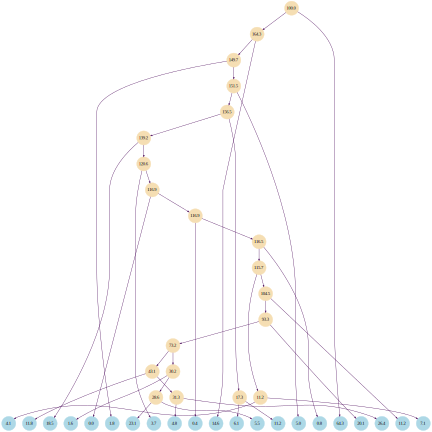

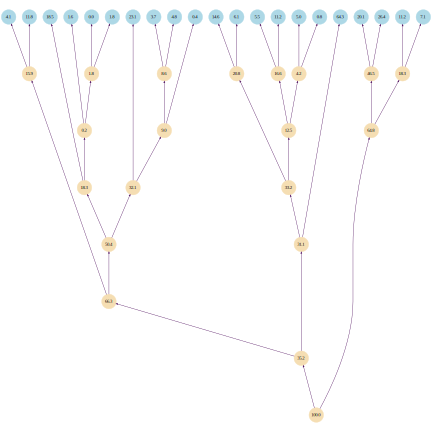

Leaves ordered according to truth jet - kt (top) vs truth (bottom) trees


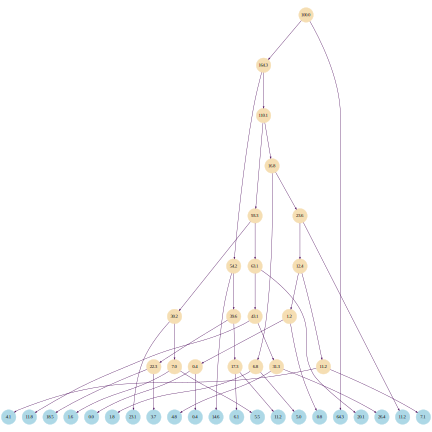

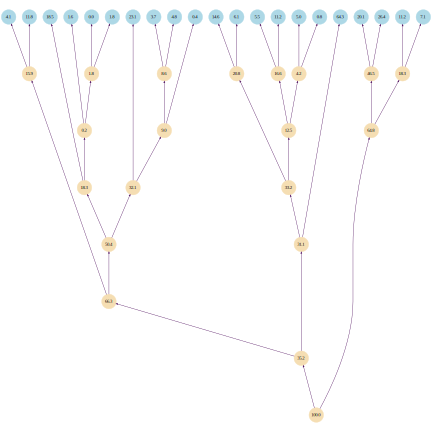

Leaves ordered according to truth jet - CA (top) vs truth (bottom) trees


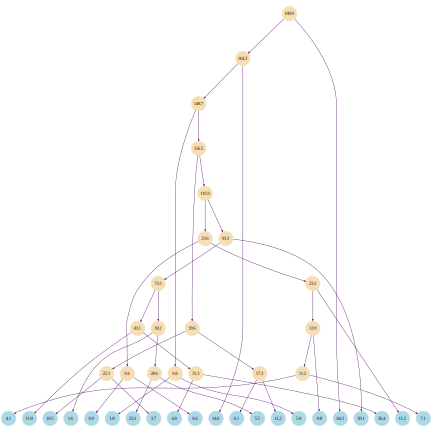

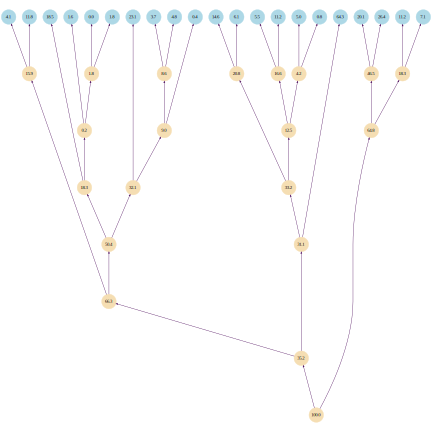

------------------------------------------------------------------------------------------
Leaves ordered in increasing py - anti-kt (top) vs truth (bottom) trees


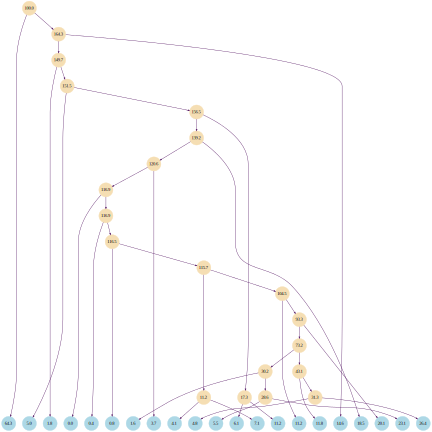

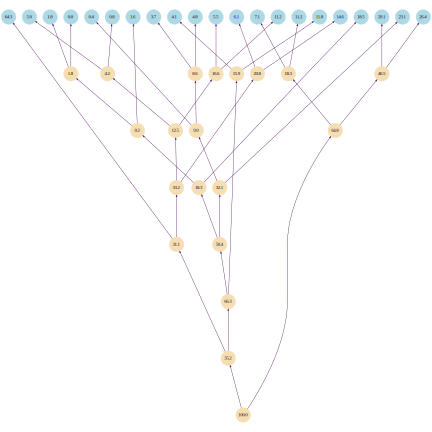

Leaves ordered in increasing py - kt (top) vs truth (bottom) trees


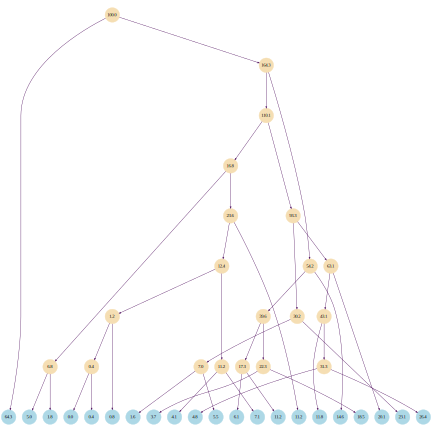

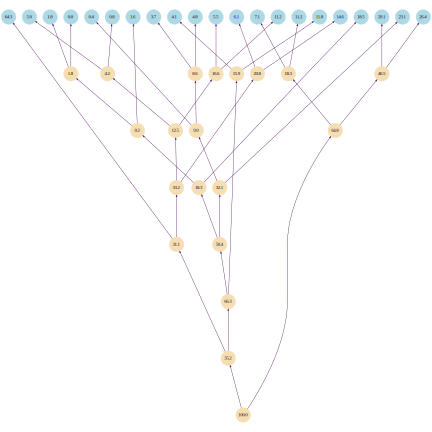

Leaves ordered in increasing py - CA (top) vs truth (bottom) trees


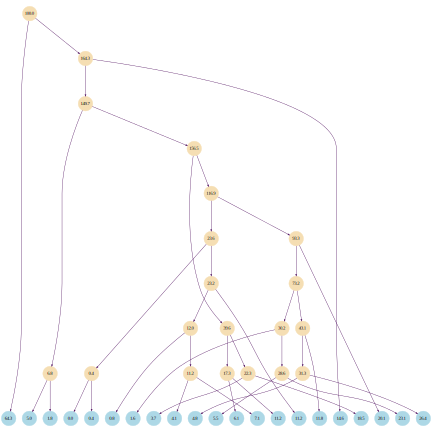

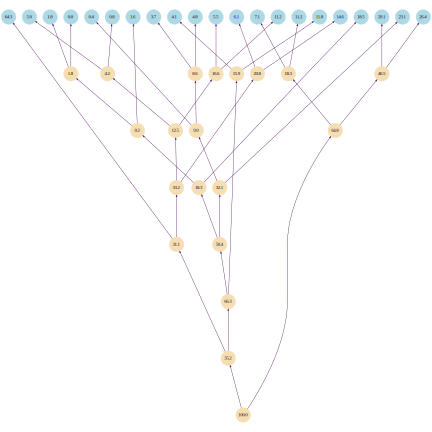

------------------------------------------------------------------------------------------
Leaves with different order - anti-kt (top) vs truth (bottom) trees


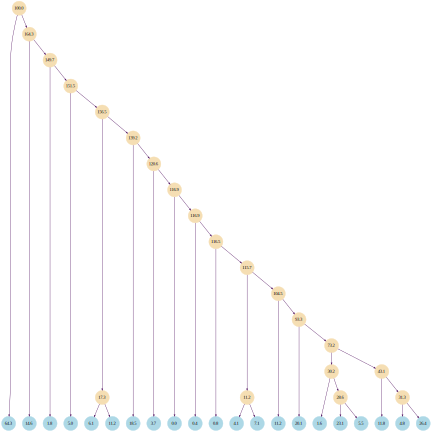

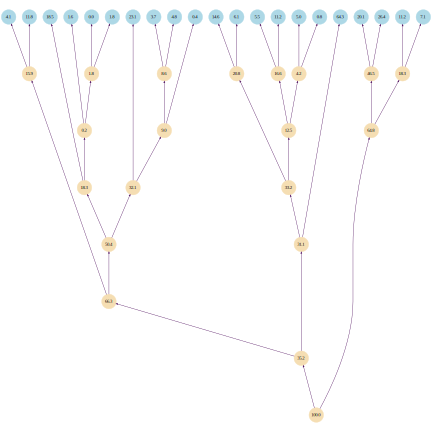

Leaves with different order - kt (top) vs truth (bottom) trees


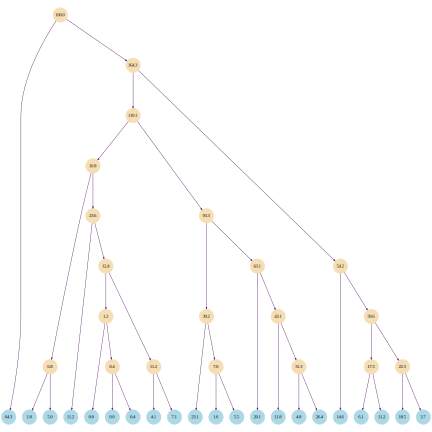

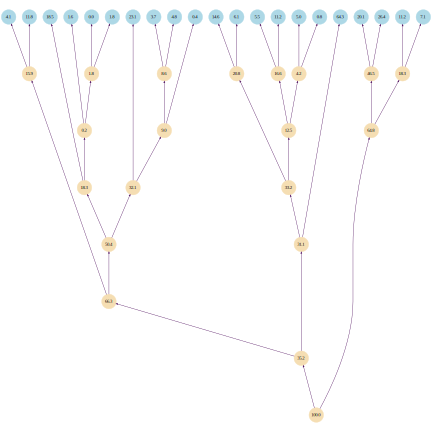

Leaves with different order - CA (top) vs truth (bottom) trees


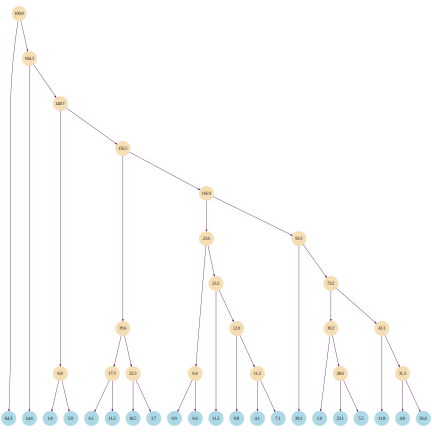

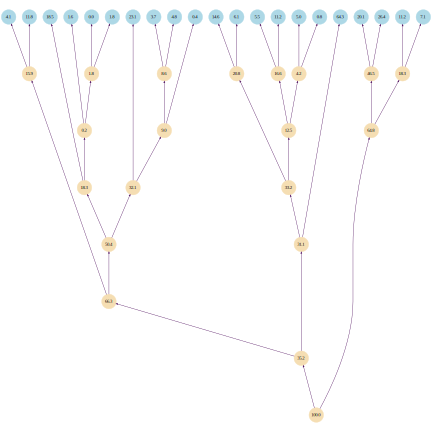

In [23]:
input_jet='tree_13_truth'
node_id_antikt, node_id_kt, node_id_CA = recluster_all(input_jet)
visualize_all(input_jet, order='truth')
visualize_all(input_jet, order='py')
visualize_all(input_jet, order=None)

out_filename= trees/antikt_tree_15_truth_-1.pkl
out_filename= trees/kt_tree_15_truth_1.pkl
out_filename= trees/CA_tree_15_truth_0.pkl
------------------------------------------------------------------------------------------
anti-kt (top) vs truth (bottom) trees


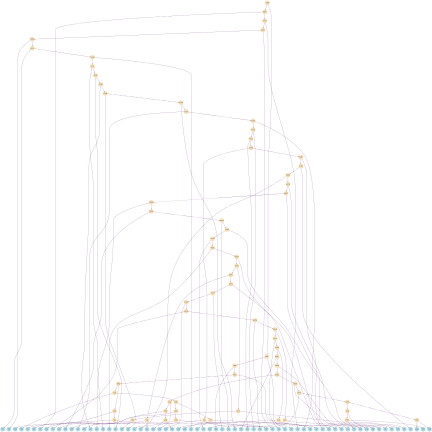

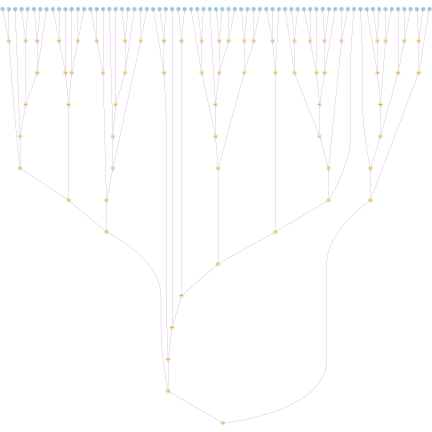

kt (top) vs truth (bottom) trees


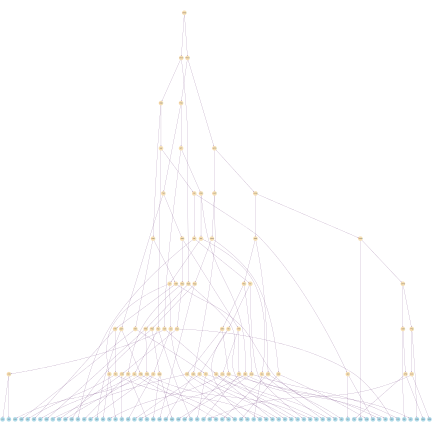

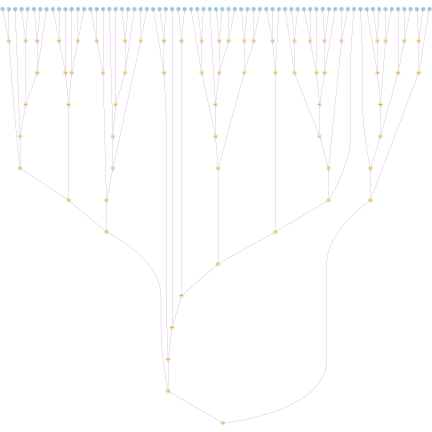

CA (top) vs truth (bottom) trees


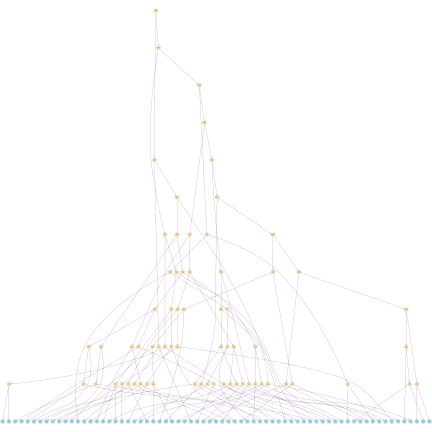

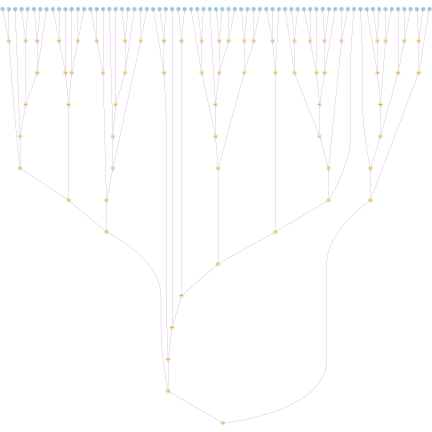

------------------------------------------------------------------------------------------
Leaves ordered in increasing py - anti-kt (top) vs truth (bottom) trees


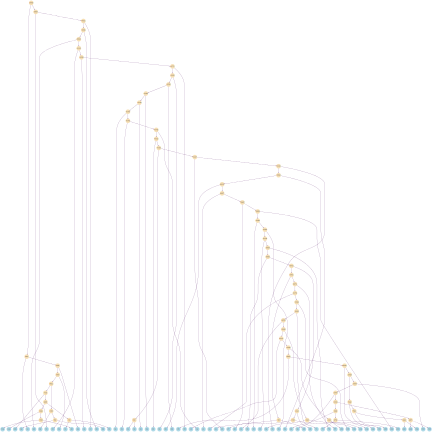

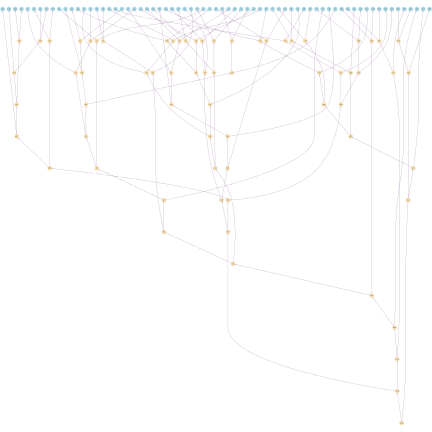

Leaves ordered in increasing py - kt (top) vs truth (bottom) trees


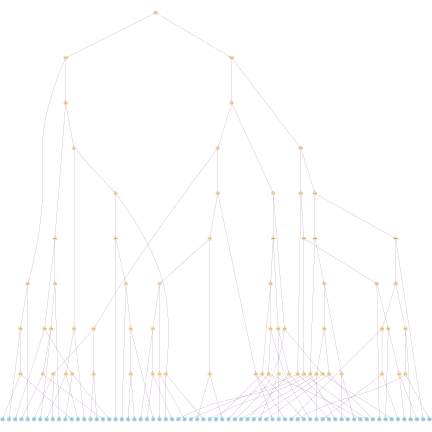

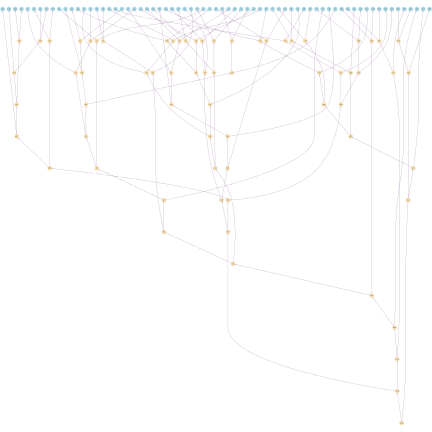

Leaves ordered in increasing py - CA (top) vs truth (bottom) trees


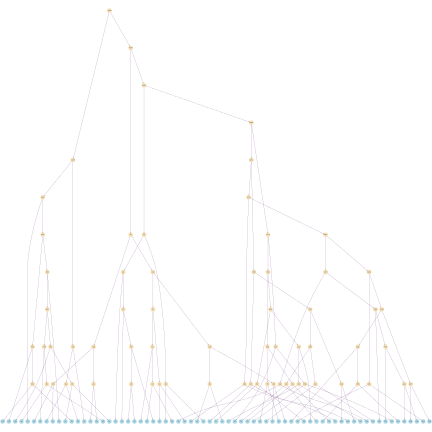

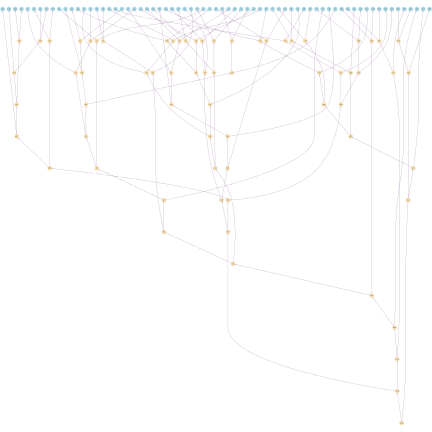

------------------------------------------------------------------------------------------
Leaves with different order - anti-kt (top) vs truth (bottom) trees


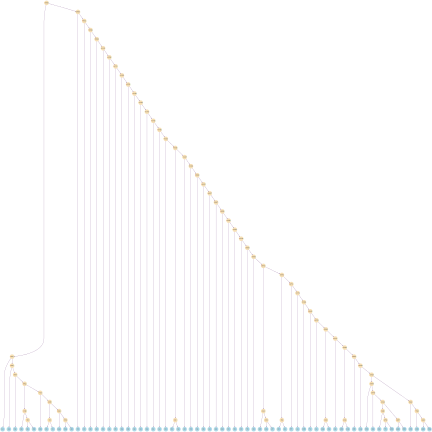

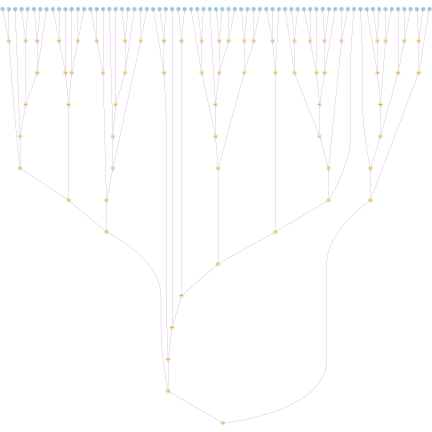

Leaves with different order - kt (top) vs truth (bottom) trees


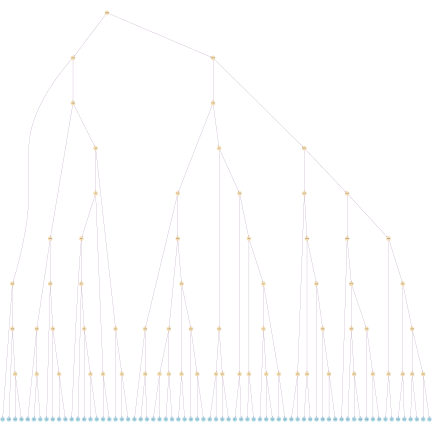

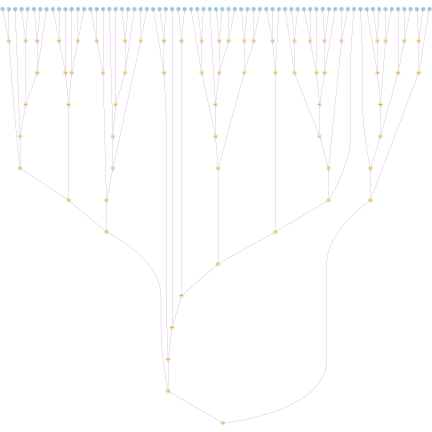

Leaves with different order - CA (top) vs truth (bottom) trees


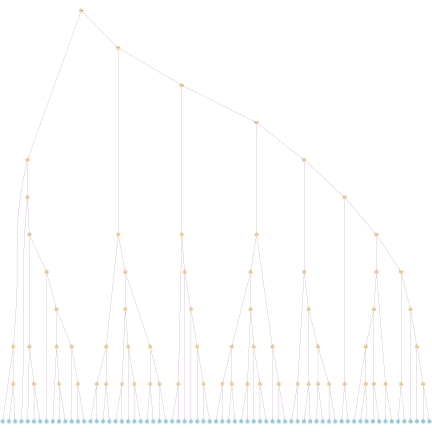

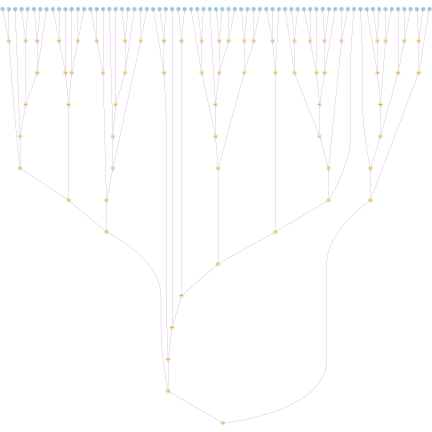

In [464]:
input_jet='tree_15_truth'
node_id_antikt, node_id_kt, node_id_CA = recluster_all(input_jet)
visualize_all(input_jet, order='truth')
visualize_all(input_jet, order='py')
visualize_all(input_jet, order=None)

In [ ]:
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)


In [ ]:

# df

In [256]:

network_lut

{'6': [0.8167028311697733, 0.5345122109266688, 0.5750280113923723]}

In [ ]:
# df.corr()

In [ ]:
import pandas as pd
import seaborn as sns
sns.set()

# Load the brain networks example dataset
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

# Select a subset of the networks
used_networks = [6]
used_columns = (df.columns.get_level_values("network")
                          .astype(int)
                          .isin(used_networks))
df = df.loc[:, used_columns]

# Create a categorical palette to identify the networks
network_pal = sns.husl_palette(8, s=.45)
network_lut = dict(zip(map(str, used_networks), network_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix
networks = df.columns.get_level_values("network")
network_colors = pd.Series(networks, index=df.columns).map(network_lut)

# Draw the full plot
# sns.clustermap(df.corr(), center=0, cmap="vlag",
#                linewidths=.75, figsize=(13, 13))

In [ ]:
# # import pandas as pd
# import pandas as pd
 
# # import numpy as np
# import numpy as np
 
# # simple array
# X2 = [2, 8, 0, 4, 1, 9, 9, 0]
# data = np.array(X)
 
# ser = pd.Series(data)
# print(ser)

In [277]:
Z2=pd.Series(X2)
Z2.corr(Z2)

1.0

In [ ]:
# sns.clustermap(Z, center=0, cmap="vlag",
#                row_colors=network_colors, col_colors=network_colors,
#                linewidths=.75, figsize=(13, 13))

In [281]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]
X

[[2], [8], [0], [4], [1], [9], [9], [0]]

In [226]:
def methodd(x):
    return 2*x

In [283]:
Z = linkage(X, method='single')
# fig = plt.figure(figsize=(25, 10))
# dn = dendrogram(Z)

In [ ]:
import seaborn as sns; sns.set(color_codes=True)
# iris = sns.load_dataset("iris")
# species = iris.pop("species")
# sns.clustermap(Z, method="single")
# sns.clustermap(Z,row_linkage=Z,col_linkage=Z)

In [285]:
# dn

In [278]:
# import seaborn as sns; sns.set(color_codes=True)
# iris = sns.load_dataset("iris")
# species = iris.pop("species")
# g = sns.clustermap(iris)

In [ ]:
Z = linkage(X, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)


In [222]:
# species